# MAG7 Portfolio Optimization with XiaoJiuCai

This notebook demonstrates how to use the XiaoJiuCai framework to optimize a portfolio of MAG7 stocks (Microsoft, Apple, Google, Amazon, Tesla, NVIDIA, and Meta). We'll use locally saved stock data and train a portfolio optimization model.

In [1]:
# Install required packages if needed
# !pip install yfinance torch numpy pandas matplotlib

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import sys
import os

# Add the project root to the path
sys.path.insert(0, os.path.abspath('..'))

# Import xiaojiucai modules
from xiaojiucai.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from xiaojiucai.models.networks import GreatNet, LSTMNet
from xiaojiucai.benchmarks import OneOverN, Random, InverseVolatility, MaximumReturn
from xiaojiucai.losses import MaximumDrawdownLoss, MeanReturnsLoss, SharpeRatioLoss, VolatilityLoss
from xiaojiucai.experiments import Run
from xiaojiucai.callbacks import EarlyStoppingCallback

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 1. Data Collection

Let's load the MAG7 stock data from a local parquet file containing multi-dimensional data.

In [3]:
# Define MAG7 stocks
mag7_tickers = ['MSFT', 'AAPL', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'META']

# Load multi-dimensional data from local parquet file
data_path = os.path.join('..', 'data', 'mag7_data_raw.parquet')

if os.path.exists(data_path):
    # Load data from local parquet file
    raw_data = pd.read_parquet(data_path)
    print(f"Data loaded from {data_path}")
    print(f"Raw data shape: {raw_data.shape}")
    print(f"Raw data columns: {raw_data.columns.levels}")
    
    # Select only the 'Close' prices for initial processing
    # In later steps, we'll use the full multi-dimensional data
    data = raw_data['Close']
    print(f"Close prices data shape: {data.shape}")
else:
    print(f"Data file not found at {data_path}")
    raise FileNotFoundError(f"Required data file not found: {data_path}")

data.head()

Data loaded from ../data/mag7_data_raw.parquet
Raw data shape: (5027, 35)
Raw data columns: [['Close', 'High', 'Low', 'Open', 'Volume'], ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']]
Close prices data shape: (5027, 7)


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2005-09-26,1.616283,2.1670,7.810992,NaN,17.601694,0.251990,NaN
2005-09-27,1.604275,2.1580,7.802541,NaN,17.650463,0.252831,NaN
2005-09-28,1.533428,2.1685,7.605204,NaN,17.880327,0.254360,NaN
2005-09-29,1.571253,2.2395,7.695174,NaN,18.068390,0.259632,NaN
2005-09-30,1.609379,2.2650,7.865171,NaN,17.922119,0.261924,NaN


In [4]:
# Check for missing data
print("Missing data:")
print(data.isnull().sum())

# Fill missing data with forward fill
data = data.ffill().bfill()
print("\nAfter filling missing data:")
print(data.isnull().sum())

Missing data:
Ticker
AAPL        0
AMZN        0
GOOGL       0
META     1674
MSFT        0
NVDA        0
TSLA     1197
dtype: int64

After filling missing data:
Ticker
AAPL     0
AMZN     0
GOOGL    0
META     0
MSFT     0
NVDA     0
TSLA     0
dtype: int64


## 2. Calculate Returns

We'll calculate the log returns from the adjusted closing prices.

In [5]:
# Calculate log returns
returns = np.log(data / data.shift(1))

# Check for NaN values in returns
print("NaN values in returns before filling:")
print(returns.isnull().sum())

# Fill NaN values using forward fill then backward fill
returns = returns.ffill().bfill()

print("\nNaN values in returns after filling:")
print(returns.isnull().sum())

print(f"\nReturns shape: {returns.shape}")
returns.head()

NaN values in returns before filling:
Ticker
AAPL     1
AMZN     1
GOOGL    1
META     1
MSFT     1
NVDA     1
TSLA     1
dtype: int64

NaN values in returns after filling:
Ticker
AAPL     0
AMZN     0
GOOGL    0
META     0
MSFT     0
NVDA     0
TSLA     0
dtype: int64

Returns shape: (5027, 7)


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2005-09-26,-0.007457,-0.004162,-0.001083,0.0,0.002767,0.003331,0.0
2005-09-27,-0.007457,-0.004162,-0.001083,0.0,0.002767,0.003331,0.0
2005-09-28,-0.045166,0.004854,-0.025617,0.0,0.012939,0.006027,0.0
2005-09-29,0.024368,0.032217,0.011761,0.0,0.010463,0.020515,0.0
2005-09-30,0.023975,0.011322,0.021851,0.0,-0.008128,0.008790,0.0


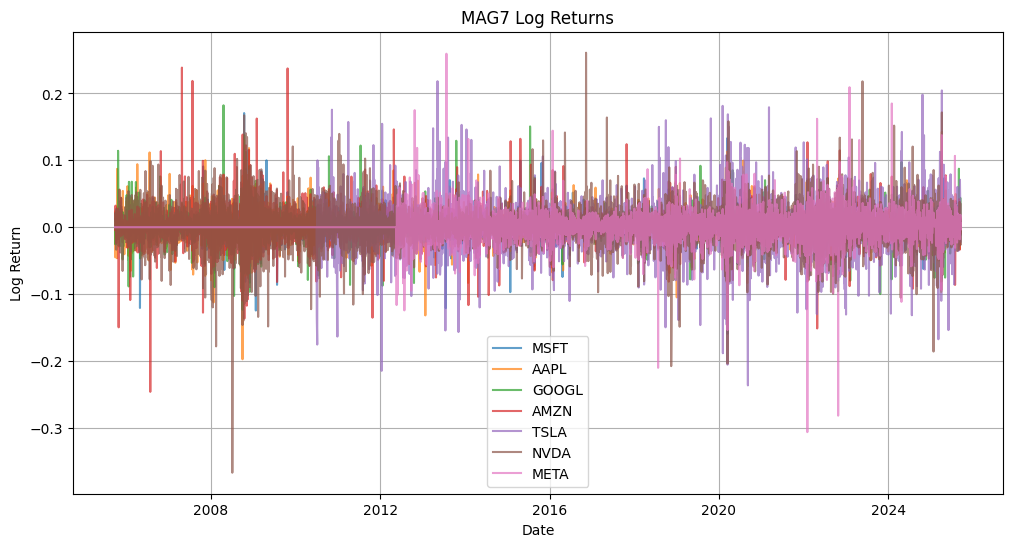

In [6]:
# Visualize the returns
plt.figure(figsize=(12, 6))
for ticker in mag7_tickers:
    if ticker in returns.columns:
        plt.plot(returns.index, returns[ticker], label=ticker, alpha=0.7)
    elif (ticker,) in returns.columns:  # Handle tuple column names
        plt.plot(returns.index, returns[(ticker,)], label=ticker, alpha=0.7)

plt.title('MAG7 Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.show()

## 3. Prepare Data for Training

We'll use a rolling window approach to create features and targets for training using multi-dimensional data.

In [7]:
# Parameters for data preparation
lookback = 60   # Use 60 days of historical data
horizon = 20    # Predict for the next 20 days
gap = 1         # No gap between lookback and horizon

# Use all available channels (Open, High, Low, Close, Volume)
channels = raw_data.columns.levels[0].tolist()
n_channels = len(channels)
n_assets = len(mag7_tickers)

print(f"Available channels: {channels}")
print(f"Number of channels: {n_channels}")
print(f"Number of assets: {n_assets}")

# Get dimensions
n_timesteps = len(raw_data)
n_samples = n_timesteps - lookback - horizon - gap + 1

print(f"Number of samples: {n_samples}")
print(f"Lookback period: {lookback} days")
print(f"Prediction horizon: {horizon} days")

Available channels: ['Close', 'High', 'Low', 'Open', 'Volume']
Number of channels: 5
Number of assets: 7
Number of samples: 4947
Lookback period: 60 days
Prediction horizon: 20 days


In [8]:
# Create features and targets using rolling window with multi-dimensional data
X_list, y_list = [], []

# Convert to numpy array with shape (n_timesteps, n_channels, n_assets)
raw_data_values = np.stack([raw_data[channel].values for channel in channels], axis=1)
print(f'Raw data shape: {raw_data_values.shape}')

# Handle NaN values in raw data using pandas Series for better filling
print("Handling NaN values in raw data...")
nan_count_before = np.isnan(raw_data_values).sum()
if nan_count_before > 0:
    print(f"  Found {nan_count_before} NaN values in raw data")
    # Create 3D array
    filled_data = np.zeros_like(raw_data_values)
    
    # Use pandas Series for each channel and asset to handle NaN values
    for channel in range(raw_data_values.shape[1]):
        for asset in range(raw_data_values.shape[2]):
            series = pd.Series(raw_data_values[:, channel, asset])
            # First try to fill forward
            series = series.ffill()
            # Then fill backward for any remaining NaNs at the start
            series = series.bfill()
            # Finally, fill any remaining NaNs with 0 (should be rare)
            series = series.fillna(0)
            filled_data[:, channel, asset] = series.values
            
    raw_data_values = filled_data
    nan_count_after = np.isnan(raw_data_values).sum()
    print(f"  After filling: {nan_count_after} NaN values remaining")
else:
    print("  No NaN values found in raw data")

# Create rolling windows
for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(raw_data_values[i - lookback: i, :, :])
    y_list.append(raw_data_values[i + gap: i + gap + horizon, :, :])

# Stack into arrays
X = np.stack(X_list, axis=0)
y = np.stack(y_list, axis=0)

print(f'Features (X) shape: {X.shape}')  # (n_samples, lookback, n_channels, n_assets)
print(f'Targets (y) shape: {y.shape}')   # (n_samples, horizon, n_channels, n_assets)

# Double check for any remaining NaN values
X_nan_count = np.isnan(X).sum()
y_nan_count = np.isnan(y).sum()
print(f"NaN values in X: {X_nan_count}")
print(f"NaN values in y: {y_nan_count}")

# If there are any remaining NaNs (which should be extremely rare), fill them
if X_nan_count > 0:
    print("Filling remaining NaNs in X with 0...")
    X = np.nan_to_num(X, nan=0.0)
if y_nan_count > 0:
    print("Filling remaining NaNs in y with 0...")
    y = np.nan_to_num(y, nan=0.0)

# Transpose to match expected format (n_samples, n_channels, lookback, n_assets)
X = np.transpose(X, (0, 2, 1, 3))
y = np.transpose(y, (0, 2, 1, 3))

print(f'Features (X) final shape: {X.shape}')
print(f'Targets (y) final shape: {y.shape}')

# Final verification
print("\nFinal NaN check:")
print(f"NaN values in X: {np.isnan(X).sum()}")
print(f"NaN values in y: {np.isnan(y).sum()}")

Raw data shape: (5027, 5, 7)
Handling NaN values in raw data...
  Found 14355 NaN values in raw data
  After filling: 0 NaN values remaining
Features (X) shape: (4947, 60, 5, 7)
Targets (y) shape: (4947, 20, 5, 7)
NaN values in X: 0
NaN values in y: 0
Features (X) final shape: (4947, 5, 60, 7)
Targets (y) final shape: (4947, 5, 20, 7)

Final NaN check:
NaN values in X: 0
NaN values in y: 0


In [9]:
# 探查数据
# print a batch to verify
print(X)

[[[[1.61628306e+00 2.16700006e+00 7.81099224e+00 ... 1.76016941e+01
    2.51990378e-01 1.59266698e+00]
   [1.60427475e+00 2.15799999e+00 7.80254126e+00 ... 1.76504631e+01
    2.52831161e-01 1.59266698e+00]
   [1.53342807e+00 2.16849995e+00 7.60520411e+00 ... 1.78803272e+01
    2.54359603e-01 1.59266698e+00]
   ...
   [2.16685224e+00 2.47399998e+00 1.05018921e+01 ... 1.88059769e+01
    2.79115587e-01 1.59266698e+00]
   [2.13473105e+00 2.46050000e+00 1.06907797e+01 ... 1.87920017e+01
    2.81559885e-01 1.59266698e+00]
   [2.14283514e+00 2.41849995e+00 1.05528421e+01 ... 1.87431068e+01
    2.76899368e-01 1.59266698e+00]]

  [[1.63789724e+00 2.17100000e+00 7.97676622e+00 ... 1.77549335e+01
    2.53748052e-01 1.66666698e+00]
   [1.62829129e+00 2.18650007e+00 7.91363673e+00 ... 1.77270835e+01
    2.55276476e-01 1.66666698e+00]
   [1.59436891e+00 2.18700004e+00 7.83137114e+00 ... 1.80196369e+01
    2.55047272e-01 1.66666698e+00]
   ...
   [2.18726618e+00 2.49749994e+00 1.05165567e+01 ... 1.89

In [10]:
# Split data into train and test
split_ratio = 0.8
split_ix = int(n_samples * split_ratio)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix, n_samples))

print(f'Train samples: {len(indices_train)}')
print(f'Test samples: {len(indices_test)}')
print(f'Train range: {indices_train[0]}:{indices_train[-1]}')
print(f'Test range: {indices_test[0]}:{indices_test[-1]}')

Train samples: 3957
Test samples: 990
Train range: 0:3956
Test range: 3957:4946


In [ ]:
# Apply log transform to handle large value ranges
X_log = np.where(X > 0, np.log1p(X), -np.log1p(-X))
y_log = np.where(y > 0, np.log1p(y), -np.log1p(-y))

# Scale log-transformed features
means, stds = prepare_standard_scaler(X_log, indices=indices_train)
print(f'Means shape: {means.shape}')
print(f'Stds shape: {stds.shape}')

# Create dataset with log-scaled data
dataset = InRAMDataset(X_log, y_log, transform=Scale(means, stds))

# Create dataloaders
batch_size = 32
dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=batch_size)

dataloader_test = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=batch_size)

print("Dataset and dataloaders created successfully!")

Means shape: (1, 5, 1, 1)
Stds shape: (1, 5, 1, 1)
Dataset and dataloaders created successfully!


In [12]:
# print a batch to verify
for X_batch, y_batch in dataloader_train:
    print(f'X_batch shape: {X_batch.shape}')  # (batch_size, n_channels, lookback, n_assets)
    print(f'y_batch shape: {y_batch.shape}')  # (batch_size, n_channels, horizon, n_assets)
    print(X_batch)
    break

X_batch shape: torch.Size([32, 1, 5, 60, 7])
y_batch shape: torch.Size([32, 5, 20, 7])
tensor([[[[[-0.6898, -0.6796, -0.5755,  ..., -0.3949, -0.7150, -0.6902],
           [-0.6900, -0.6798, -0.5757,  ..., -0.3940, -0.7149, -0.6902],
           [-0.6913, -0.6796, -0.5793,  ..., -0.3897, -0.7149, -0.6902],
           ...,
           [-0.6796, -0.6740, -0.5259,  ..., -0.3726, -0.7145, -0.6902],
           [-0.6802, -0.6742, -0.5224,  ..., -0.3729, -0.7144, -0.6902],
           [-0.6801, -0.6750, -0.5249,  ..., -0.3738, -0.7145, -0.6902]],

          [[-0.6961, -0.6864, -0.5805,  ..., -0.4023, -0.7213, -0.6956],
           [-0.6963, -0.6861, -0.5817,  ..., -0.4028, -0.7213, -0.6956],
           [-0.6969, -0.6861, -0.5832,  ..., -0.3974, -0.7213, -0.6956],
           ...,
           [-0.6861, -0.6804, -0.5342,  ..., -0.3807, -0.7208, -0.6956],
           [-0.6864, -0.6804, -0.5300,  ..., -0.3811, -0.7208, -0.6956],
           [-0.6862, -0.6804, -0.5238,  ..., -0.3838, -0.7208, -0.6956]],

 

In [13]:
# Create network models
great_net = GreatNet(n_assets, lookback, n_channels=n_channels)
lstm_net = LSTMNet(n_assets, lookback, n_channels=n_channels, hidden_size=64, num_layers=2)

# Create benchmark models
benchmarks = {
    '1/N': OneOverN(),
    'Random': Random(),
    'Inverse Volatility': InverseVolatility(),
    'Maximum Return': MaximumReturn()
}

print("Models created successfully!")
print(f"GreatNet: {great_net}")
print(f"LSTMNet: {lstm_net}")

Models created successfully!
GreatNet: GreatNet(
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (dense_layer): Linear(in_features=2100, out_features=7, bias=True)
  (allocate_layer): SoftmaxAllocator()
)
LSTMNet: LSTMNet(
  (lstm): LSTM(35, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (dense_layer): Linear(in_features=64, out_features=7, bias=True)
  (allocate_layer): SoftmaxAllocator()
)


In [14]:
# Define loss function
# 使用更细粒度的权重平衡，让风险控制和收益目标更平衡
loss = (
    0.2 * MaximumDrawdownLoss() +     # 最大回撤损失（风险控制）
    0.3 * MeanReturnsLoss() +         # 平均收益率损失（收益目标）
    0.3 * SharpeRatioLoss() +         # 夏普比率损失（风险调整收益）
    0.2 * VolatilityLoss()            # 波动率损失（风险控制）
)

print("Loss function defined with balanced weights!")

Loss function defined with balanced weights!


## 7. Train the Models

We'll train both the GreatNet and LSTMNet models.

In [ ]:
# Train GreatNet with gradient clipping and learning rate scheduler
print("Training GreatNet...")
optimizer = torch.optim.Adam(great_net.parameters(), lr=0.0001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                      factor=0.5, patience=5,
                                                      verbose=True)

great_net_run = Run(great_net,
                    loss,
                    dataloader_train,
                    val_dataloaders={'test': dataloader_test},
                    optimizer=optimizer,
                    callbacks=[
                        EarlyStoppingCallback(
                            metric_name='loss',
                            dataloader_name='test',
                            patience=15
                        )
                    ],
                    grad_clip_value=1.0)  # Add gradient clipping

great_net_history = great_net_run.launch(50)

print("GreatNet training completed!")

Training GreatNet...
        nan, nan, nan, nan, nan, nan, nan, nan], grad_fn=<AddBackward0>)
Weights range: [0.032187, 0.443028]
Batch x range: [-0.721540, 8.418708]
Batch y range: [0.273690, 2356955904.000000]
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan], grad_fn=<AddBackward0>)
Weights range: [0.018507, 0.631829]
Batch x range: [-0.721143, 7.754902]
Batch y range: [0.327557, 2663768832.000000]
        -29.6565,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan], grad_fn=<AddBackward0>)
Weights range: [0.013144, 0.512087]
Batch x range: [-0.7

In [ ]:
# Train LSTMNet
print("Training LSTMNet...")
lstm_net_run = Run(lstm_net,
                   loss,
                   dataloader_train,
                   val_dataloaders={'test': dataloader_test},
                   optimizer=torch.optim.Adam(lstm_net.parameters(), amsgrad=True, lr=0.001),
                   callbacks=[EarlyStoppingCallback(metric_name='loss',
                                                    dataloader_name='test',
                                                    patience=10)])

lstm_net_history = lstm_net_run.launch(50)

print("LSTMNet training completed!")

Training LSTMNet...
Epoch 1 metrics:
  train loss: nan
  test loss: nan


KeyboardInterrupt: 

## 8. Evaluate Models

Let's evaluate the trained models and compare them with benchmarks.

In [ ]:
# Add trained models to benchmarks
benchmarks['GreatNet'] = great_net
benchmarks['LSTMNet'] = lstm_net

# Define metrics for evaluation
metrics = {
    'Max Drawdown': MaximumDrawdownLoss(),
    'Mean Return': MeanReturnsLoss(),
    'Sharpe Ratio': SharpeRatioLoss(),
    'Volatility': VolatilityLoss()
}

print("Evaluation metrics defined!")

Evaluation metrics defined!


## 9. Visualize Results

Let's visualize the training progress and model performance.

In [ ]:
# Plot training history for GreatNet
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_loss = great_net_history.metrics[
    (great_net_history.metrics['dataloader'] == 'train') & 
    (great_net_history.metrics['metric'] == 'loss')
]
plt.plot(train_loss['epoch'], train_loss['value'], label='Train Loss')

val_loss = great_net_history.metrics[
    (great_net_history.metrics['dataloader'] == 'test') & 
    (great_net_history.metrics['metric'] == 'loss')
]
plt.plot(val_loss['epoch'], val_loss['value'], label='Validation Loss')
plt.title('GreatNet Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
train_loss = lstm_net_history.metrics[
    (lstm_net_history.metrics['dataloader'] == 'train') & 
    (lstm_net_history.metrics['metric'] == 'loss')
]
plt.plot(train_loss['epoch'], train_loss['value'], label='Train Loss')

val_loss = lstm_net_history.metrics[
    (lstm_net_history.metrics['dataloader'] == 'test') & 
    (lstm_net_history.metrics['metric'] == 'loss')
]
plt.plot(val_loss['epoch'], val_loss['value'], label='Validation Loss')
plt.title('LSTMNet Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 10. Conclusion

In this notebook, we've demonstrated how to:
1. Load stock data from a local file
2. Prepare the data for training using a rolling window approach
3. Create dataset and data loaders
4. Define and train neural network models for portfolio optimization
5. Evaluate the models against traditional benchmarks

The XiaoJiuCai framework provides a flexible and extensible approach to portfolio optimization using deep learning techniques.